# Marks

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.anova import AnovaRM
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
def format_marks(session):
    """Format marks data for a given session"""
    # Read the file with violin's marks
    df = pd.read_csv(
        f"/home/hugo/Thèse/playing-in/data/raw/CNSM/Ouverture par le jeu/notes/Liste participant⋅es - Session {session}.csv"
    )

    # Drop unnecessary columns
    df = df.drop(
        [
            "Jour",
            "Horaire",
            "Ord 1",
            "Ord 2",
            "Rq A",
            "Rq B",
            "Rq C",
            "Rq D",
            "Rq E",
            "Unnamed: 26",
        ],
        axis="columns",
    )

    # Split columns name for A.P A.F ...
    columns_split = np.array([col.split(".") for col in df.columns[2:]])
    tiles = np.tile(columns_split, (len(df), 1))

    # Create a new dataframe with splitted columns as values
    df_long = pd.DataFrame(tiles, columns=["Violon", "Critère"])

    # Create a new dataframe with splitted columns as values
    df_long["Note"] = df.iloc[:, 2:].values.flatten()
    df_long["Condition"] = "aveugle"
    df_long["Sujet"] = df["Nom"].repeat(len(df.columns) - 2).values
    df_long["Session"] = session

    # Handle non-blind conditions
    df_long.loc[df_long["Violon"] == "D", ["Condition", "Violon"]] = [
        "non-aveugle",
        "A",
    ]
    df_long.loc[df_long["Violon"] == "E", ["Condition", "Violon"]] = [
        "non-aveugle",
        "B",
    ]

    df_long.to_csv(f"session{session}.csv")

    return df_long


df_sessions = [format_marks(i) for i in [1, 2, 3]]
df = pd.concat(df_sessions, ignore_index=True)
df = df.replace({"A": "Klimke", "B": "Levaggi", "C": "Stoppani"})

## Plots

/tmp/ipykernel_65915/10793043.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


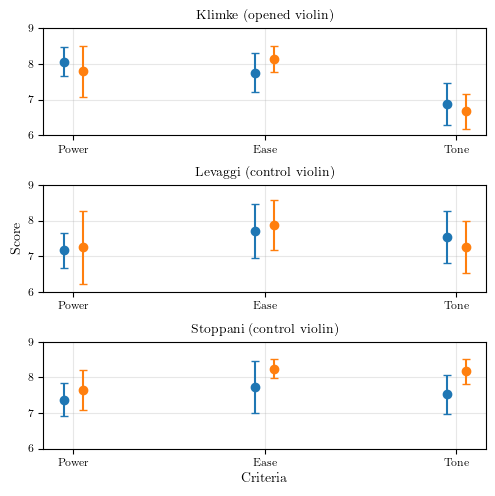

In [22]:
plt_df = df[(df.Condition == "aveugle") & (df.Session != 2)]

groups = plt_df.groupby(by=["Violon", "Critère", "Session"], sort=False)["Note"].agg(
    ["mean", "std", "count"]
)

mpl.style.use("/home/hugo/Thèse/common/styles.mplstyle")
fig, axs = plt.subplots(3, figsize=(5, 5))

session_colors = {1: "C0", 3: "C1"}
violin_positions = {"Klimke": 0, "Levaggi": 1, "Stoppani": 2}
critere_positions = {
    "P": 0,
    "F": 1,
    "T": 2,
}

for (violin, critere, session), data in groups.iterrows():
    ax_idx = violin_positions[violin]
    x_pos = critere_positions[critere]

    margin = 0.05
    offset = margin if session == 3 else -margin

    axs[ax_idx].errorbar(
        x_pos + offset,
        data["mean"],
        yerr=1.96 / np.sqrt(data["count"]) * data["std"],
        fmt="o",
        color=session_colors[session],
        capsize=3,
    )

# Set up axes labels and titles
critere_labels = ["Power", "Ease", "Tone"]  # Adjust based on your data
for i, (violin, _) in enumerate(violin_positions.items()):
    axs[i].set_xticks([0, 1, 2], critere_labels)
    axs[i].set_title(
        f"{violin}{' (opened violin)' if violin == 'Klimke' else ' (control violin)'}"
    )
    axs[i].set_ylim([6, 9])
    axs[i].grid(True)

axs[-1].set_xlabel("Criteria")
axs[1].set_ylabel("Score")

fig.show()
fig.savefig("../reports/figures/marks.png")

## Statistical Test

In [31]:
df = df[(df.Condition == "aveugle") & (df.Violon == "A") & (df.Session != 2)]

# Delete empty rows
df = df[df["Note"] > 0]

# Keep only subjects who participated in all sessions
sujets1 = set(df.query("Session==1")["Sujet"])
sujets2 = set(df.query("Session==3")["Sujet"])
sujets3 = set(df.query("Session==3")["Sujet"])
df = df[df["Sujet"].isin(sujets1.intersection(sujets2, sujets3))]

# Delete third violin
# df = df[df.Violon != "C"]
# df.to_csv(f"session.csv")

print(df["Sujet"].value_counts())

# Define the relevant factors
factors = ["Critère", "Session"]

# For each factor, list the unique levels and the count of occurrences for each level
factor_levels = {factor: df[factor].value_counts() for factor in factors}

# Display the shape of each level
for factor, levels in factor_levels.items():
    print(f"Factor: {factor}")
    print(levels)
    print("\n")


# Définir l'ANOVA répétée
anova = AnovaRM(df, "Note", "Sujet", within=factors)

# Compute ANOVA
resultats = anova.fit()
resultats.anova_table = np.round(resultats.anova_table, 3)
resultats.anova_table["Num DF"] = resultats.anova_table["Num DF"].astype("int")
resultats.anova_table["Den DF"] = resultats.anova_table["Den DF"].astype("int")

# Afficher les résultats
print(resultats.anova_table)

resultats.anova_table.to_html("anova.html", justify="unset", border=0)

# anova = pg.anova(data=df, dv='Note', between=['Session', 'Condition', 'Violon', 'Critère'], ss_type=2).round(3)
# anova = anova.set_index('Source')
# anova.to_html('anova.html', justify='unset', float_format='{:10.2f}'.format, border=0)
# print(anova)

Sujet
Paul       6
Renato     6
Areski     6
Félix      6
Céleste    6
SMD        6
Clara      6
Norimi     6
Fanton     6
Lucie      6
Eugénie    6
Name: count, dtype: int64
Factor: Critère
Critère
P    22
F    22
T    22
Name: count, dtype: int64


Factor: Session
Session
1    33
3    33
Name: count, dtype: int64


                 F Value  Num DF  Den DF  Pr > F
Critère           11.303       2      20   0.001
Session            0.341       1      10   0.572
Critère:Session    1.523       2      20   0.242
